In [1]:
import os

# Define workspace path
WORKSPACE_PATH = "/data/horse/ws/uskh580e-myws"

# Set environment variables to store large files in workspace
os.environ["HF_HOME"] = os.path.join(WORKSPACE_PATH, "huggingface")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(WORKSPACE_PATH, "huggingface")
os.environ["HF_DATASETS_CACHE"] = os.path.join(WORKSPACE_PATH, "datasets")
os.environ["NLTK_DATA"] = os.path.join(WORKSPACE_PATH, "nltk_data")

# Ensure necessary directories exist
os.makedirs(os.environ["HF_HOME"], exist_ok=True)
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
os.makedirs(os.environ["HF_DATASETS_CACHE"], exist_ok=True)
os.makedirs(os.environ["NLTK_DATA"], exist_ok=True)

print(f"Workspace set up at: {WORKSPACE_PATH}")


Workspace set up at: /data/horse/ws/uskh580e-myws


In [2]:
!pip install groq


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import nltk
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from groq import Groq
import time

# Ensure NLTK resources are downloaded to workspace
nltk.data.path.append(os.environ["NLTK_DATA"])
nltk.download("punkt", download_dir=os.environ["NLTK_DATA"])
nltk.download("stopwords", download_dir=os.environ["NLTK_DATA"])

# Define BM25 Index path in workspace
BM25_INDEX_PATH = os.path.join(WORKSPACE_PATH, "bm25_index.pkl")


[nltk_data] Downloading package punkt to
[nltk_data]     /data/horse/ws/uskh580e-myws/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /data/horse/ws/uskh580e-myws/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
class BM25Retriever:
    def __init__(self, corpus_df, text_column="abstract", stopword_removal=True, use_stemming=True):
        """
        BM25 Retriever for document retrieval.

        Parameters:
        - corpus_df: Pandas DataFrame containing the corpus
        - text_column: Column in corpus_df that contains the text for retrieval
        - stopword_removal: Whether to remove stopwords
        - use_stemming: Whether to apply stemming
        """
        self.corpus_df = corpus_df
        self.text_column = text_column
        self.stopword_removal = stopword_removal
        self.use_stemming = use_stemming
        self.bm25 = None
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words("english"))

    def tokenize_and_stem(self, text):
        """ Tokenize, remove stopwords, and apply stemming (if enabled). """
        tokens = word_tokenize(text.lower())  # Tokenize & lowercase
        if self.stopword_removal:
            tokens = [token for token in tokens if token not in self.stop_words]  # Remove stopwords
        if self.use_stemming:
            tokens = [self.stemmer.stem(token) for token in tokens]  # Apply stemming
        return tokens

    def create_index(self):
        """ Create BM25 index from the corpus. """
        print("Tokenizing and processing corpus...")
        self.corpus_df["tokens"] = self.corpus_df[self.text_column].astype(str).apply(self.tokenize_and_stem)
        self.bm25 = BM25Okapi(self.corpus_df["tokens"].tolist())

    def save_index(self, filename=BM25_INDEX_PATH):
        """ Save BM25 index to workspace. """
        with open(filename, "wb") as f:
            pickle.dump(self.bm25, f)
        print(f"BM25 index saved to {filename}")

    def load_index(self, filename=BM25_INDEX_PATH):
        """ Load BM25 index from workspace. """
        with open(filename, "rb") as f:
            self.bm25 = pickle.load(f)
        print(f"BM25 index loaded from {filename}")

    def retrieve(self, query, k=10):
        """ Retrieve top-k documents for a query. """
        tokenized_query = self.tokenize_and_stem(query)
        scores = self.bm25.get_scores(tokenized_query)
        ranked_indices = np.argsort(scores)[::-1][:k]
        return self.corpus_df.iloc[ranked_indices]["corpusid"].tolist()


In [5]:
from datasets import load_dataset
import os

# Define workspace path
WORKSPACE_PATH = "/data/horse/ws/uskh580e-myws"

# Define dataset cache directory within workspace
DATASET_CACHE_DIR = os.path.join(WORKSPACE_PATH, "huggingface_datasets")

# Ensure the directory exists
os.makedirs(DATASET_CACHE_DIR, exist_ok=True)

# Load datasets and store them in workspace cache
query_data = load_dataset("princeton-nlp/LitSearch", "query", split="full", cache_dir=DATASET_CACHE_DIR)
corpus_clean_data = load_dataset("princeton-nlp/LitSearch", "corpus_clean", split="full", cache_dir=DATASET_CACHE_DIR)
corpus_s2orc_data = load_dataset("princeton-nlp/LitSearch", "corpus_s2orc", split="full", cache_dir=DATASET_CACHE_DIR)

print("Datasets loaded successfully and stored in:", DATASET_CACHE_DIR)


Datasets loaded successfully and stored in: /data/horse/ws/uskh580e-myws/huggingface_datasets


In [6]:
query_df = query_data.to_pandas()
corpus_clean_df = corpus_clean_data.to_pandas()
corpus_s2orc_df = corpus_s2orc_data.to_pandas()

In [7]:
corpus_df = corpus_clean_df

In [8]:
query_df.head()

,query_set,query,specificity,quality,corpusids
0,inline_acl,Are there any research papers on methods to co...,0,2,[202719327]
1,inline_acl,Are there any resources available for translat...,1,2,[227231792]
2,inline_acl,Are there any studies that explore post-hoc te...,0,2,"[226254579, 204976362]"
3,inline_acl,Are there any tools or studies that have focus...,1,2,"[10961392, 12160022]"
4,inline_acl,Are there papers that propose contextualized c...,1,2,[233296182]


In [9]:
corpus_df.head()

,corpusid,title,abstract,citations,full_paper
0,252715594,PHENAKI: VARIABLE LENGTH VIDEO GENERATION FROM...,"We present Phenaki, a model capable of realist...","[6628106, 174802916, 238582653]",PHENAKI: VARIABLE LENGTH VIDEO GENERATION FROM...
1,13002849,MODE REGULARIZED GENERATIVE ADVERSARIAL NETWORKS,Although Generative Adversarial Networks achie...,[],MODE REGULARIZED GENERATIVE ADVERSARIAL NETWOR...
2,239998253,What Do We Mean by Generalization in Federated...,Federated learning data is drawn from a distri...,"[235613568, 231924480, 211678094, 195798643, 4...",What Do We Mean by Generalization in Federated...
3,62841605,SPREADING VECTORS FOR SIMILARITY SEARCH,Discretizing multi-dimensional data distributi...,[],SPREADING VECTORS FOR SIMILARITY SEARCH\n\n\nA...
4,253237531,MACHINE UNLEARNING OF FEDERATED CLUSTERS,Federated clustering (FC) is an unsupervised l...,[],MACHINE UNLEARNING OF FEDERATED CLUSTERS\n\n\n...


In [10]:
import nltk
import os

# Define the workspace path
WORKSPACE_PATH = "/data/horse/ws/uskh580e-myws"
NLTK_PATH = os.path.join(WORKSPACE_PATH, "nltk_data")

# Ensure directory exists
os.makedirs(NLTK_PATH, exist_ok=True)

# Set NLTK data path
nltk.data.path.append(NLTK_PATH)

# Force download punkt & stopwords
nltk.download("punkt", download_dir=NLTK_PATH, force=True)
nltk.download("stopwords", download_dir=NLTK_PATH, force=True)


[nltk_data] Downloading package punkt to
[nltk_data]     /data/horse/ws/uskh580e-myws/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /data/horse/ws/uskh580e-myws/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
import os
print(os.listdir(NLTK_PATH + "/tokenizers"))


['punkt.zip', 'punkt']


In [12]:
from nltk.tokenize import word_tokenize

text = "This is a test sentence for NLTK tokenization."
tokens = word_tokenize(text.lower())

print(tokens)


['this', 'is', 'a', 'test', 'sentence', 'for', 'nltk', 'tokenization', '.']


In [13]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [14]:
import os
import nltk

# Define workspace path
WORKSPACE_PATH = "/data/horse/ws/uskh580e-myws"
NLTK_PATH = os.path.join(WORKSPACE_PATH, "nltk_data")

# Ensure NLTK data directory exists
os.makedirs(NLTK_PATH, exist_ok=True)

# Append NLTK path
nltk.data.path.append(NLTK_PATH)

# Download required NLTK resources directly to workspace
nltk.download("punkt", download_dir=NLTK_PATH)
nltk.download("stopwords", download_dir=NLTK_PATH)

print(f"NLTK resources downloaded to: {NLTK_PATH}")


NLTK resources downloaded to: /data/horse/ws/uskh580e-myws/nltk_data


[nltk_data] Downloading package punkt to
[nltk_data]     /data/horse/ws/uskh580e-myws/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /data/horse/ws/uskh580e-myws/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
nltk.data.path.append('/root/nltk_data/')
nltk.data.path.append('/usr/local/share/nltk_data/')
nltk.data.path.append('/usr/share/nltk_data/')

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from typing import List, Any, Tuple
from datasets import Dataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from enum import Enum
import openai
import pickle
from InstructorEmbedding import INSTRUCTOR
import sentence_transformers
from datasets import load_dataset

/data/horse/ws/uskh580e-llm_citation_ws/myenv/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /data/horse/ws/uskh580e-myws/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /data/horse/ws/uskh580e-myws/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
nltk.data.path.append('/root/nltk_data/')
nltk.data.path.append('/usr/local/share/nltk_data/')
nltk.data.path.append('/usr/share/nltk_data/')

In [21]:
import os
import nltk

# Define workspace path
WORKSPACE_PATH = "/data/horse/ws/uskh580e-myws"
NLTK_PATH = os.path.join(WORKSPACE_PATH, "nltk_data")

# Ensure directory exists
os.makedirs(NLTK_PATH, exist_ok=True)

# Set NLTK data path
nltk.data.path.append(NLTK_PATH)

print(f"NLTK resources will be stored in: {NLTK_PATH}")


NLTK resources will be stored in: /data/horse/ws/uskh580e-myws/nltk_data


In [22]:
nltk.download("punkt", download_dir=NLTK_PATH, force=True)
nltk.download("stopwords", download_dir=NLTK_PATH, force=True)


[nltk_data] Downloading package punkt to
[nltk_data]     /data/horse/ws/uskh580e-myws/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /data/horse/ws/uskh580e-myws/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
import os
print(os.listdir(NLTK_PATH + "/tokenizers"))


['punkt.zip', 'punkt']


In [24]:
from nltk.tokenize import word_tokenize

text = "This is a test sentence for NLTK tokenization."
tokens = word_tokenize(text.lower())

print(tokens)  # Expected output: ['this', 'is', 'a', 'test', 'sentence', 'for', 'nltk', 'tokenization', '.']


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/data/horse/ws/uskh580e-myws/nltk_data'
    - '/home/uskh580e/nltk_data'
    - '/data/horse/ws/uskh580e-llm_citation_ws/myenv/nltk_data'
    - '/data/horse/ws/uskh580e-llm_citation_ws/myenv/share/nltk_data'
    - '/data/horse/ws/uskh580e-llm_citation_ws/myenv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/data/horse/ws/uskh580e-myws/nltk_data'
    - '/data/horse/ws/uskh580e-myws/nltk_data'
    - '/root/nltk_data/'
    - '/usr/local/share/nltk_data/'
    - '/usr/share/nltk_data/'
    - '/root/nltk_data/'
    - '/usr/local/share/nltk_data/'
    - '/usr/share/nltk_data/'
    - '/data/horse/ws/uskh580e-myws/nltk_data'
**********************************************************************


In [20]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

text = "This is a test sentence for NLTK tokenization."
tokens = word_tokenize(text.lower())

print(tokens)  # Expected output: ['this', 'is', 'a', 'test', 'sentence', 'for', 'nltk', 'tokenization', '.']


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/data/horse/ws/uskh580e-myws/nltk_data'
    - '/home/uskh580e/nltk_data'
    - '/data/horse/ws/uskh580e-llm_citation_ws/myenv/nltk_data'
    - '/data/horse/ws/uskh580e-llm_citation_ws/myenv/share/nltk_data'
    - '/data/horse/ws/uskh580e-llm_citation_ws/myenv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/data/horse/ws/uskh580e-myws/nltk_data'
    - '/data/horse/ws/uskh580e-myws/nltk_data'
    - '/root/nltk_data/'
    - '/usr/local/share/nltk_data/'
    - '/usr/share/nltk_data/'
    - '/root/nltk_data/'
    - '/usr/local/share/nltk_data/'
    - '/usr/share/nltk_data/'
**********************************************************************


In [15]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

# Define workspace path
WORKSPACE_PATH = "/data/horse/ws/uskh580e-myws"

# Ensure workspace directory exists
os.makedirs(WORKSPACE_PATH, exist_ok=True)

# Define BM25 Index path in workspace
BM25_INDEX_PATH = os.path.join(WORKSPACE_PATH, "bm25_index.pkl")

# Initialize BM25 Retriever
bm25_retriever = BM25Retriever(corpus_df)

# Check if BM25 index exists in workspace
if os.path.exists(BM25_INDEX_PATH):
    print("Loading existing BM25 index from workspace...")
    bm25_retriever.load_index(BM25_INDEX_PATH)
else:
    print("Creating BM25 index...")
    bm25_retriever.create_index()
    bm25_retriever.save_index(BM25_INDEX_PATH)

# Retrieve documents and evaluate performance
retrieval_results = []

for _, row in tqdm(query_df.iterrows(), total=len(query_df), desc="Retrieving documents"):
    query_text = row["query"]

    # Convert corpus IDs to list safely
    try:
        relevant_ids = eval(row["corpusids"]) if isinstance(row["corpusids"], str) else row["corpusids"]
        relevant_ids = list(relevant_ids) if isinstance(relevant_ids, (np.ndarray, set)) else relevant_ids
    except:
        relevant_ids = []

    retrieved_ids = bm25_retriever.retrieve(query_text, k=10)

    # Ensure relevant_ids is not empty before computing metrics
    if len(relevant_ids) == 0:
        recall_5, recall_10, mrr, ap = 0, 0, 0, 0
    else:
        recall_5 = len(set(retrieved_ids[:5]) & set(relevant_ids)) / len(relevant_ids)
        recall_10 = len(set(retrieved_ids[:10]) & set(relevant_ids)) / len(relevant_ids)
        mrr = next((1 / (i + 1) for i, doc_id in enumerate(retrieved_ids) if doc_id in relevant_ids), 0)
        ap = sum((1 / (i + 1)) for i, doc_id in enumerate(retrieved_ids) if doc_id in relevant_ids) / len(relevant_ids)

    retrieval_results.append({
        "query": query_text,
        "retrieved": retrieved_ids,
        "relevant": relevant_ids,
        "Recall@5": recall_5,
        "Recall@10": recall_10,
        "MRR": mrr,
        "AP": ap
    })

# Convert results to DataFrame
results_df = pd.DataFrame(retrieval_results)

# Save retrieval results to workspace
RESULTS_PATH = os.path.join(WORKSPACE_PATH, "retrieval_results.csv")
results_df.to_csv(RESULTS_PATH, index=False)
print(f"Retrieval results saved at: {RESULTS_PATH}")

display(results_df)


Creating BM25 index...
Tokenizing and processing corpus...
BM25 index saved to /data/horse/ws/uskh580e-myws/bm25_index.pkl


Retrieving documents: 100%|███████████████████████████████████████████████████████████| 597/597 [02:43<00:00,  3.65it/s]


Retrieval results saved at: /data/horse/ws/uskh580e-myws/retrieval_results.csv


,query,retrieved,relevant,Recall@5,Recall@10,MRR,AP
0,Are there any research papers on methods to co...,"[248227350, 221995575, 257038997, 256461337, 2...",[202719327],0.0,0.0,0.000000,0.000000
1,Are there any resources available for translat...,"[233365022, 227231792, 6825507, 252432736, 199...",[227231792],1.0,1.0,0.500000,0.500000
2,Are there any studies that explore post-hoc te...,"[226254579, 254823170, 256000114, 251468136, 2...","[226254579, 204976362]",0.5,0.5,1.000000,0.500000
3,Are there any tools or studies that have focus...,"[7859600, 472215, 262349699, 9792162, 17929137...","[10961392, 12160022]",0.0,0.0,0.000000,0.000000
4,Are there papers that propose contextualized c...,"[247594202, 10685297, 253244504, 212747810, 24...",[233296182],0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...
592,Which paper trains on linear regression to hyp...,"[203838325, 14409460, 222341655, 40928473, 222...",[262054014],0.0,0.0,0.000000,0.000000
593,Which paper uses the latent diffusion model fo...,"[261706069, 259937490, 263334587, 254044710, 2...",[263334587],1.0,1.0,0.333333,0.333333
594,Which paper utilized MMD flows with Riesz kern...,"[258823075, 263671662, 238259607, 214802067, 3...",[263671662],1.0,1.0,0.500000,0.500000
595,What paper provides generalization bounds for ...,"[253111598, 254247299, 257482844, 238582773, 2...",[263830433],0.0,0.0,0.000000,0.000000


In [16]:
import numpy as np

# Compute Mean Recall@5, Recall@10, MRR, and MAP
mean_recall_5 = results_df["Recall@5"].mean()
mean_recall_10 = results_df["Recall@10"].mean()
mean_mrr = results_df["MRR"].mean()
mean_ap = results_df["AP"].mean()  # Mean Average Precision

# Store in dictionary
aggregated_metrics = {
    "Mean Recall@5": mean_recall_5,
    "Mean Recall@10": mean_recall_10,
    "Mean Reciprocal Rank (MRR)": mean_mrr,
    "Mean Average Precision (MAP)": mean_ap
}

# Display the results
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Aggregated Retrieval Metrics", dataframe=pd.DataFrame([aggregated_metrics]))

# Also print results for quick reference
print("\n🔹 Aggregated Retrieval Metrics 🔹")
for metric, value in aggregated_metrics.items():
    print(f"{metric}: {value:.4f}")



🔹 Aggregated Retrieval Metrics 🔹
Mean Recall@5: 0.3878
Mean Recall@10: 0.4574
Mean Reciprocal Rank (MRR): 0.3013
Mean Average Precision (MAP): 0.2951


In [17]:
def zero_shot_prompt(query, retrieved_docs):
    """Zero-shot prompting: Simply pass the query and retrieved context."""
    context = "\n".join(retrieved_docs)
    prompt = f"""
    Given the following retrieved documents, answer the question concisely.

    Retrieved Documents:
    {context}

    Question: {query}
    Answer:
    """
    return prompt


def few_shot_prompt(query, retrieved_docs):
    """Few-shot prompting: Provide examples before asking the query."""
    examples = """
    Example 1:
    Question: What is the main contribution of the BERT model?
    Answer: The BERT model introduced bidirectional context learning using the transformer architecture.
    
    Example 2:
    Question: How does retrieval-augmented generation work?
    Answer: It improves factual consistency by retrieving external documents before text generation.
    """

    context = "\n".join(retrieved_docs)
    prompt = f"""
    Below are examples of well-formatted responses, followed by your question.

    {examples}

    Retrieved Documents:
    {context}

    Question: {query}
    Answer:
    """
    return prompt


def chain_of_thought_prompt(query, retrieved_docs):
    """Chain-of-thought (CoT) prompting: Encourage step-by-step reasoning."""
    context = "\n".join(retrieved_docs)
    prompt = f"""
    Let's break down the answer step by step to ensure factual accuracy.

    Retrieved Documents:
    {context}

    Question: {query}
    
    Step 1: Identify the key concepts in the question.
    Step 2: Search the retrieved documents for relevant passages.
    Step 3: Construct a well-supported answer using the retrieved information.
    
    Answer:
    """
    return prompt


In [18]:
from groq import Groq

# Initialize Groq API
API_KEY = "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"
client = Groq(api_key=API_KEY)

def query_llama3(prompt):
    """Send a query to LLaMA-3 using Groq API."""
    response = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content


In [ ]:
from groq import Groq
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Initialize Groq API client
groq_client = Groq(api_key="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")

# Define function for different prompting strategies
def generate_with_rag(query, retrieved_docs, strategy="zero-shot"):
    """
    Uses Groq API to generate an answer using retrieved documents with different prompting strategies.
    
    Parameters:
    - query (str): The question to be answered.
    - retrieved_docs (list): Retrieved document texts.
    - strategy (str): Prompting strategy ("zero-shot", "few-shot", "chain-of-thought").
    
    Returns:
    - str: Generated response from the model.
    """

    context = "\n".join(retrieved_docs)  # Join retrieved documents into one string
    
    # Define different prompts based on the strategy
    if strategy == "zero-shot":
        prompt = f"""Use the following retrieved documents to answer the question:
        {context}

        Question: {query}
        Answer:"""

    elif strategy == "few-shot":
        prompt = f"""Here are examples of how to answer questions using retrieved documents:

        Example 1:
        Context: [Paper 1: Deep Learning for NLP, Paper 2: Transformer Models]
        Question: How do transformer models compare to LSTMs?
        Answer: Transformer models generally outperform LSTMs in NLP tasks due to their ability to capture long-range dependencies.

        Example 2:
        Context: [Paper 3: Reinforcement Learning in AI, Paper 4: RL Applications]
        Question: What is reinforcement learning used for?
        Answer: Reinforcement learning is commonly used in robotics, game playing, and automated control tasks.

        Now answer the following question using retrieved documents:
        Context: {context}
        Question: {query}
        Answer:"""

    elif strategy == "chain-of-thought":
        prompt = f"""Let's break down the question step by step using the retrieved documents.

        Step 1: Analyze the question and identify key concepts.
        Step 2: Search for relevant supporting evidence in the retrieved documents.
        Step 3: Construct a logical answer based on the evidence.

        Retrieved Documents:
        {context}

        Now, following these steps, answer the question:
        Question: {query}
        Answer:"""

    # Generate response
    response = groq_client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[
            {"role": "system", "content": "You are an AI that generates well-supported answers using retrieved documents."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content  # Return the generated answer


# Run RAG on all queries for each prompting strategy
rag_results = []

for _, row in tqdm(query_df.iterrows(), total=len(query_df), desc="Running RAG with different strategies"):
    query_text = row["query"]

    # Retrieve top-5 documents
    retrieved_ids = bm25_retriever.retrieve(query_text, k=5)
    retrieved_docs = corpus_df.loc[corpus_df["corpusid"].isin(retrieved_ids), "abstract"].tolist()

    # Test all three prompting strategies
    for strategy in ["zero-shot", "few-shot", "chain-of-thought"]:
        generated_answer = generate_with_rag(query_text, retrieved_docs, strategy)

        # Store results
        rag_results.append({
            "query": query_text,
            "strategy": strategy,
            "retrieved": retrieved_docs,
            "generated_answer": generated_answer
        })

# Convert to DataFrame
rag_results_df = pd.DataFrame(rag_results)

# Save results to workspace
RAG_RESULTS_PATH = os.path.join(WORKSPACE_PATH, "rag_results.csv")
rag_results_df.to_csv(RAG_RESULTS_PATH, index=False)

# Display results
import ace_tools as tools
tools.display_dataframe_to_user(name="RAG Prompting Comparison", dataframe=rag_results_df)


Running RAG with different strategies:  15%|██████                                   | 88/597 [34:31<2:41:57, 19.09s/it]

In [19]:
#Only LLM response
generated_results = []

for _, row in tqdm(results_df.iterrows(), total=len(results_df), desc="Generating responses"):
    query_text = row["query"]
    retrieved_docs = row["retrieved"]  # Retrieved document IDs

    # Convert retrieved document IDs to actual text
    retrieved_texts = corpus_df[corpus_df["corpusid"].isin(retrieved_docs)]["abstract"].tolist()

    # Generate responses using different strategies
    zero_shot_response = query_llama3(zero_shot_prompt(query_text, retrieved_texts))
    few_shot_response = query_llama3(few_shot_prompt(query_text, retrieved_texts))
    cot_response = query_llama3(chain_of_thought_prompt(query_text, retrieved_texts))

    # Store results
    generated_results.append({
        "query": query_text,
        "retrieved": retrieved_texts,
        "zero_shot_response": zero_shot_response,
        "few_shot_response": few_shot_response,
        "cot_response": cot_response,
        "relevant": row["relevant"]
    })

# Convert to DataFrame and save
generated_df = pd.DataFrame(generated_results)
GEN_RESULTS_PATH = os.path.join(WORKSPACE_PATH, "generated_responses.csv")
generated_df.to_csv(GEN_RESULTS_PATH, index=False)
print(f"Generated responses saved at: {GEN_RESULTS_PATH}")

display(generated_df)


Generating responses:   4%|██▍                                                       | 25/597 [16:18<6:12:56, 39.12s/it]


KeyboardInterrupt: 

In [8]:
import os

# Set Hugging Face cache directory to your workspace
os.environ["HF_HOME"] = "/data/horse/ws/uskh580e-myws/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/data/horse/ws/uskh580e-myws/huggingface"
os.environ["HF_DATASETS_CACHE"] = "/data/horse/ws/uskh580e-myws/datasets"
BM25_INDEX_PATH = "/data/horse/ws/uskh580e-myws/bm25_index.pkl"

def save_index(self, filename=BM25_INDEX_PATH):
    """ Save BM25 index to workspace. """
    with open(filename, "wb") as f:
        pickle.dump(self.bm25, f)
    print(f"BM25 index saved to {filename}")

def load_index(self, filename=BM25_INDEX_PATH):
    """ Load BM25 index from workspace. """
    with open(filename, "rb") as f:
        self.bm25 = pickle.load(f)
    print(f"BM25 index loaded from {filename}")



In [9]:
import os
import json
from typing import List, Any, Tuple
from datasets import Dataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from enum import Enum
import openai
import pickle

In [3]:
from InstructorEmbedding import INSTRUCTOR
from gritlm import GritLM
import sentence_transformers
from datasets import load_dataset
query_data = load_dataset("princeton-nlp/LitSearch", "query", split="full")
corpus_clean_data = load_dataset("princeton-nlp/LitSearch", "corpus_clean", split="full")
corpus_s2orc_data = load_dataset("princeton-nlp/LitSearch", "corpus_s2orc", split="full")

In [4]:
query_df = query_data.to_pandas()
corpus_clean_df = corpus_clean_data.to_pandas()
corpus_s2orc_df = corpus_s2orc_data.to_pandas()

In [5]:
query_df.head()

,query_set,query,specificity,quality,corpusids
0,inline_acl,Are there any research papers on methods to co...,0,2,[202719327]
1,inline_acl,Are there any resources available for translat...,1,2,[227231792]
2,inline_acl,Are there any studies that explore post-hoc te...,0,2,"[226254579, 204976362]"
3,inline_acl,Are there any tools or studies that have focus...,1,2,"[10961392, 12160022]"
4,inline_acl,Are there papers that propose contextualized c...,1,2,[233296182]


In [7]:
def count_corpusids(df, column_name="corpusids"):
    return df[column_name].apply(lambda x: len(eval(x)) if isinstance(x, str) else len(x))

query_df["corpusid_count"] = count_corpusids(query_df)

In [8]:
query_df.head()

,query_set,query,specificity,quality,corpusids,corpusid_count
0,inline_acl,Are there any research papers on methods to co...,0,2,[202719327],1
1,inline_acl,Are there any resources available for translat...,1,2,[227231792],1
2,inline_acl,Are there any studies that explore post-hoc te...,0,2,"[226254579, 204976362]",2
3,inline_acl,Are there any tools or studies that have focus...,1,2,"[10961392, 12160022]",2
4,inline_acl,Are there papers that propose contextualized c...,1,2,[233296182],1


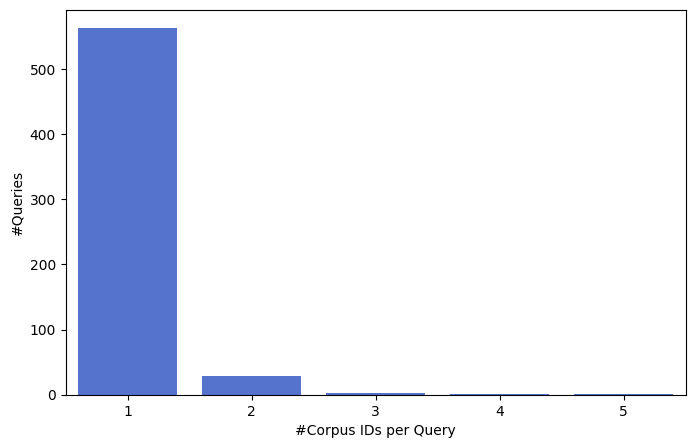

In [16]:
import seaborn as sns

corpusid_distribution = query_df["corpusid_count"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=corpusid_distribution.index, y=corpusid_distribution.values, color="royalblue")
plt.xlabel("#Corpus IDs per Query")
plt.ylabel("#Queries")
plt.xticks(rotation=0)

plt.show()

In [6]:
corpus_clean_df.head()


,corpusid,title,abstract,citations,full_paper
0,252715594,PHENAKI: VARIABLE LENGTH VIDEO GENERATION FROM...,"We present Phenaki, a model capable of realist...","[6628106, 174802916, 238582653]",PHENAKI: VARIABLE LENGTH VIDEO GENERATION FROM...
1,13002849,MODE REGULARIZED GENERATIVE ADVERSARIAL NETWORKS,Although Generative Adversarial Networks achie...,[],MODE REGULARIZED GENERATIVE ADVERSARIAL NETWOR...
2,239998253,What Do We Mean by Generalization in Federated...,Federated learning data is drawn from a distri...,"[235613568, 231924480, 211678094, 195798643, 4...",What Do We Mean by Generalization in Federated...
3,62841605,SPREADING VECTORS FOR SIMILARITY SEARCH,Discretizing multi-dimensional data distributi...,[],SPREADING VECTORS FOR SIMILARITY SEARCH\n\n\nA...
4,253237531,MACHINE UNLEARNING OF FEDERATED CLUSTERS,Federated clustering (FC) is an unsupervised l...,[],MACHINE UNLEARNING OF FEDERATED CLUSTERS\n\n\n...


In [7]:
corpus_s2orc_df.head()

,corpusid,externalids,content,year
0,252715594,"{'acl': None, 'arxiv': '2210.02399', 'dblp': '...","{'annotations': {'abstract': '[{""end"":2761,""st...",2023.0
1,13002849,"{'acl': None, 'arxiv': '1612.02136', 'dblp': '...","{'annotations': {'abstract': '[{""end"":1726,""st...",2017.0
2,239998253,"{'acl': None, 'arxiv': None, 'dblp': 'conf/icl...","{'annotations': {'abstract': '[{""end"":1082,""st...",2022.0
3,62841605,"{'acl': None, 'arxiv': '1806.03198', 'dblp': '...","{'annotations': {'abstract': '[{""end"":1503,""st...",2019.0
4,253237531,"{'acl': None, 'arxiv': '2210.16424', 'dblp': '...","{'annotations': {'abstract': '[{""end"":2886,""st...",2023.0


In [11]:
print(corpus_clean_df['full_paper'].iloc[0])


PHENAKI: VARIABLE LENGTH VIDEO GENERATION FROM OPEN DOMAIN TEXTUAL DESCRIPTIONS


Ruben Villegas 
University of Michigan
University College London


Google Brain 
University of Michigan
University College London


Mohammad Babaeizadeh 
University of Michigan
University College London


Google Brain 
University of Michigan
University College London


Pieter-Jan Kindermans 
University of Michigan
University College London


Google Brain 
University of Michigan
University College London


Hernan Moraldo hmoraldo@google.com 
University of Michigan
University College London


Google Brain 
University of Michigan
University College London


Han Zhang zhanghan@google.com 
University of Michigan
University College London


Google Brain 
University of Michigan
University College London


Mohammad Taghi 
University of Michigan
University College London


Saffar Google Brain 
University of Michigan
University College London


Santiago Castro sacastro@umich.edu 
University of Michigan
University C

In [13]:
corpus_clean_df.astype(str).nunique()


corpusid      64183
title         56717
abstract      55909
citations     44680
full_paper    63725
dtype: int64

In [14]:
corpus_s2orc_df.astype(str).nunique()

corpusid       64183
externalids    64053
content        64177
year              60
dtype: int64

In [15]:
print(corpus_s2orc_df['content'].iloc[0])

{'annotations': {'abstract': '[{"end":2761,"start":1313}]', 'author': '[{"end":149,"start":83},{"end":214,"start":150},{"end":287,"start":215},{"end":352,"start":288},{"end":426,"start":353},{"end":491,"start":427},{"end":578,"start":492},{"end":643,"start":579},{"end":725,"start":644},{"end":790,"start":726},{"end":857,"start":791},{"end":929,"start":858},{"end":1016,"start":930},{"end":1081,"start":1017},{"end":1166,"start":1082},{"end":1231,"start":1167}]', 'authoraffiliation': '[{"end":148,"start":99},{"end":213,"start":164},{"end":286,"start":237},{"end":351,"start":302},{"end":425,"start":376},{"end":490,"start":441},{"end":577,"start":528},{"end":642,"start":593},{"end":724,"start":675},{"end":789,"start":740},{"end":856,"start":807},{"end":928,"start":879},{"end":1015,"start":966},{"end":1080,"start":1031},{"end":1165,"start":1116},{"end":1230,"start":1181}]', 'authorfirstname': '[{"end":88,"start":83},{"end":156,"start":150},{"end":223,"start":215},{"end":294,"start":288},{"en

In [17]:
query_counts = query_df.groupby('query_set').size().reset_index(name='count')
print(query_counts)


       query_set  count
0     inline_acl     98
1  inline_nonacl    253
2     manual_acl    155
3    manual_iclr     91


In [19]:
#for loading json files into 'data'
def read_json(filename: str, silent: bool = False) -> List[Any]:
    with open(filename, 'r') as file:
        if filename.endswith(".json"):
            data = json.load(file)
        elif filename.endswith(".jsonl"):
            data = [json.loads(line) for line in file]
        else:
            raise ValueError("Input file must be either a .json or .jsonl file")

    if not silent:
        print(f"Loaded {len(data)} records from {filename}")
    return data

In [20]:
#for writing data into json file format
def write_json(data: List[Any], filename: str, silent: bool = False) -> None:
    if filename.endswith(".json"):
        with open(filename, 'w') as file:
            json.dump(data, file, indent=4)
    elif filename.endswith(".jsonl"):
        with open(filename, 'w') as file:
            for item in data:
                file.write(json.dumps(item) + "\n")
    else:
        raise ValueError("Output file must be either a .json or .jsonl file")

    if not silent:
        print(f"Saved {len(data)} records to {filename}")

In [21]:
def calculate_recall(retrieved: List[int], relevant_docs: List[int]) -> float:
    """Calculate recall metric."""
    num_relevant_retrieved = len(set(retrieved).intersection(set(relevant_docs)))
    num_relevant = len(relevant_docs)
    return num_relevant_retrieved / num_relevant if num_relevant > 0 else 0

In [22]:
def calculate_ndcg(retrieved: List[int], relevant_docs: List[int]) -> float:
    """Calculate Normalized Discounted Cumulative Gain."""
    dcg = sum(1 / (idx + 1) for idx, docid in enumerate(retrieved) if docid in relevant_docs)
    idcg = sum(1 / (idx + 1) for idx in range(len(relevant_docs)))
    return dcg / idcg if idcg > 0 else 0

In [23]:
from enum import Enum

class TextType(Enum):
    KEY = 1
    QUERY = 2

# KVStore Class
class KVStore:
    """Key-Value store base class for retrieval systems."""
    def __init__(self, index_name: str, index_type: str) -> None:
        self.index_name = index_name
        self.index_type = index_type
        self.keys = []
        self.encoded_keys = []
        self.values = []

    def __len__(self) -> int:
        return len(self.keys)

    def _encode(self, text: str, type: TextType) -> Any:
        return self._encode_batch([text], type, show_progress_bar=False)[0]

    def clear(self) -> None:
        self.keys = []
        self.encoded_keys = []
        self.values = []

    def create_index(self, key_value_pairs: List[Tuple[str, Any]]) -> None:
        if len(self.keys) > 0:
            raise ValueError("Index is not empty. Please create a new index or clear the existing one.")

        for key, value in tqdm(key_value_pairs.items(), desc=f"Creating {self.index_name} index"):
            self.keys.append(key)
            self.values.append(value)
        self.encoded_keys = self._encode_batch(self.keys, TextType.KEY)

    def save(self, dir_name: str) -> None:
        save_dict = {}
        for key, value in self.__dict__.items():
            if key[0] != "_":  # Ignore private attributes
                save_dict[key] = value

        print(f"Saving index to {os.path.join(dir_name, f'{self.index_name}.{self.index_type}')}")
        os.makedirs(dir_name, exist_ok=True)
        with open(os.path.join(dir_name, f"{self.index_name}.{self.index_type}"), 'wb') as file:
            pickle.dump(save_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

    def query(self, query_text: str, n: int, return_keys: bool = False) -> List[Any]:
        """
        Query the index and return the top-N results.

        :param query_text: The query text.
        :param n: The number of top results to return.
        :param return_keys: Whether to return keys with values.
        :return: A list of results.
        """
        encoded_query = self._encode(query_text, TextType.QUERY)
        indices = self._query(encoded_query, n)
        if return_keys:
            results = [(self.keys[i], self.values[i]) for i in indices]
        else:
            results = [self.values[i] for i in indices]
        return results




In [24]:
class GTR(KVStore):
    def __init__(self, index_name: str, model_path: str = "sentence-transformers/gtr-t5-large"):
        super().__init__(index_name, 'gtr')
        self.model_path = model_path
        self._model = sentence_transformers.SentenceTransformer(model_path, device="cpu")



    def _encode_batch(self, texts: List[str], type: TextType, show_progress_bar: bool = True) -> List[Any]:
        return self._model.encode(texts, batch_size=256, show_progress_bar=show_progress_bar).astype(np.float16)

    def load(self, path: str):
        super().load(path)
        self._model = sentence_transformers.SentenceTransformer(model_path, device="cpu")

        return self

    def _query(self, encoded_query: Any, n: int) -> List[int]:
      cosine_similarities = cosine_similarity([encoded_query], self.encoded_keys)[0]
      top_indices = cosine_similarities.argsort()[-n:][::-1]
      return top_indices


In [25]:
import nltk
import numpy as np
from tqdm import tqdm
from rank_bm25 import BM25Okapi
from typing import List, Tuple, Any


class BM25(KVStore):
    def __init__(self, index_name: str):
        super().__init__(index_name, 'bm25')

        nltk.download('punkt')
        nltk.download('stopwords')

        self._tokenizer = nltk.word_tokenize
        self._stop_words = set(nltk.corpus.stopwords.words('english'))
        self._stemmer = nltk.stem.PorterStemmer().stem
        self.index = None   # BM25 index

    def _encode_batch(self, texts: str, type: TextType, show_progress_bar: bool = True) -> List[str]:
        # lowercase, tokenize, remove stopwords, and stem
        tokens_list = []
        for text in tqdm(texts, disable=not show_progress_bar):
            tokens = self._tokenizer(text.lower())
            tokens = [token for token in tokens if token not in self._stop_words]
            tokens = [self._stemmer(token) for token in tokens]
            tokens_list.append(tokens)
        return tokens_list

    def _query(self, encoded_query: List[str], n: int) -> List[int]:
        top_indices = np.argsort(self.index.get_scores(encoded_query))[::-1][:n].tolist()
        return top_indices

    def clear(self) -> None:
        super().clear()
        self.index = None
    
    def create_index(self, key_value_pairs: List[Tuple[str, Any]]) -> None:
        super().create_index(key_value_pairs)
        self.index = BM25Okapi(self.encoded_keys)
    
    def load(self, dir_name: str) -> None:
        super().load(dir_name)
        self._tokenizer = nltk.word_tokenize
        self._stop_words = set(nltk.corpus.stopwords.words('english'))
        self._stemmer = nltk.stem.PorterStemmer().stem
        return self

In [26]:
class E5(KVStore):
    def __init__(self, index_name: str, model_path: str = "intfloat/e5-large-v2"):
        super().__init__(index_name, 'e5')
        self.model_path = model_path
        self._model = sentence_transformers.SentenceTransformer(model_path, device="cuda", cache_folder=utils.get_cache_dir()).bfloat16()
    
    def _format_text(self, text: str, type: TextType) -> str:
        if type == TextType.KEY:
            text = "passage: " + text
        elif type == TextType.QUERY:
            text = "query: " + text
        else:
            raise ValueError("Invalid TextType")
        return text
    
    def _encode_batch(self, texts: List[str], type: TextType, show_progress_bar: bool = True) -> List[Any]:
        texts = [self._format_text(text, type) for text in texts]
        return self._model.encode(texts, batch_size=256, normalize_embeddings=True, show_progress_bar=show_progress_bar).astype(np.float16)
    
    def _query(self, encoded_query: Any, n: int) -> List[int]:
        cosine_similarities = cosine_similarity([encoded_query], self.encoded_keys)[0]
        top_indices = cosine_similarities.argsort()[-n:][::-1]
        return top_indices
    
    def load(self, path: str):
        super().load(path)
        self._model = sentence_transformers.SentenceTransformer(self.model_path, device="cuda", cache_folder=utils.get_cache_dir())
        return self

In [27]:
class GRIT(KVStore):
    def __init__(self, index_name: str, raw_instruction: str, model_path: str = "GritLM/GritLM-7B"):
        super().__init__(index_name, 'grit')
        self.model_path = model_path
        self.raw_instruction = raw_instruction
        self._model = GritLM(model_path, torch_dtype="auto", device_map="auto", mode="embedding")
    
    def _get_instruction(self, type: TextType) -> str:
        if type == TextType.KEY:
            return "<|embed|>\n"
        elif type == TextType.QUERY:
            return "<|user|>\n" + self.raw_instruction + "\n<|embed|>\n"
        else:
            raise ValueError("Invalid TextType")
    
    def _encode_batch(self, texts: List[str], type: TextType, show_progress_bar: bool = True) -> List[Any]:
        return self._model.encode(texts, batch_size=256, instruction=self._get_instruction(type), show_progress_bar=show_progress_bar).astype(np.float16)
    
    def _query(self, encoded_query: Any, n: int) -> List[int]:
        try:
            cosine_similarities = cosine_similarity([encoded_query], self.encoded_keys)[0]
        except:
            for i, encoded_key in enumerate(self.encoded_keys):
                if np.any(np.isnan(encoded_key)):
                    self.encoded_keys[i] = np.zeros_like(encoded_key)
            cosine_similarities = cosine_similarity([encoded_query], self.encoded_keys)[0]
        top_indices = cosine_similarities.argsort()[-n:][::-1]
        return top_indices
    
    def load(self, path: str):
        super().load(path)
        self._model = GritLM(self.model_path, torch_dtype="auto", device_map="auto", mode="embedding")
        return self

In [28]:
class Instructor(KVStore):
    def __init__(self, index_name: str, key_instruction: str, query_instruction: str, model_path: str = "hkunlp/instructor-xl"):
        super().__init__(index_name, 'instructor')
        self.model_path = model_path
        self.key_instruction = key_instruction
        self.query_instruction = query_instruction
        self._model = INSTRUCTOR(model_path, device="cuda", cache_folder=utils.get_cache_dir())
    
    def _format_text(self, text: str, type: TextType) -> List[str]:
        if type == TextType.KEY:
            return [self.key_instruction, text]
        elif type == TextType.QUERY:
            return [self.query_instruction, text]
        else:
            raise ValueError("Invalid TextType")
    
    def _encode_batch(self, texts: List[str], type: TextType, show_progress_bar: bool = True) -> List[Any]:
        texts = [self._format_text(text, type) for text in texts]
        return self._model.encode(texts, batch_size=128, normalize_embeddings=True, show_progress_bar=show_progress_bar).astype(np.float16)
    
    def _query(self, encoded_query: Any, n: int) -> List[int]:
        cosine_similarities = cosine_similarity([encoded_query], self.encoded_keys)[0]
        top_indices = cosine_similarities.argsort()[-n:][::-1]
        return top_indices
    
    def load(self, path: str):
        super().load(path)
        self._model = INSTRUCTOR(self.model_path, device="cuda", cache_folder=utils.get_cache_dir())
        return self
        

In [31]:
def evaluate_index(index_name: str, dataset_path: str, top_k: int = 200):
    query_set = [query for query in datasets.load_dataset(dataset_path, "query", split="full")]
    index = load_index(index_name)
    for query in tqdm(query_set):
        query_text = query["query"]
        top_k_results = index.query(query_text, top_k)
        query["retrieved"] = top_k_results
    return query_set


In [34]:
#utils stuff:
import openai
from typing import List

class OPENAIBaseEngine():
    def __init__(self, model_name: str, azure: bool = True):
        if not azure:
            raise NotImplementedError("Only Azure API is supported")
        
        self.model_name = model_name
        self.client = openai.AzureOpenAI()
    
    def safe_completion(self, messages: List[dict], max_tokens: int = 2000, temperature: float = 0, top_p: float = 1):
        args_dict = {
            "max_tokens": max_tokens,
            "temperature": temperature,
            "top_p": top_p,
        }
        if top_p == 1.0: 
            args_dict.pop("top_p")
        
        response = self.client.chat.completions.create(model=self.model_name, messages=messages, **args_dict).to_dict()
        return {
            "finish_reason": response["choices"][0]["finish_reason"],
            "content": response["choices"][0]["message"]["content"]
        }
    
    def test_api(self):
        print("Testing API connection")
        messages = [{"role": "user", "content": "Why did the chicken cross the road?"}]
        response = self.safe_completion(messages=messages, max_tokens=20, temperature=0, top_p=1.0)
        content = response["content"]

        if response["finish_reason"] == 'api_error':
            print(f'Error in connecting to API: {response}')
        else:
            print(f'Successful API connection: {content}')

In [35]:
import os
import copy
import json
import datasets
from tqdm import tqdm
from typing import List, Tuple


###### QUERY CONSTRUCTION FUNCTIONS ######
def create_prompt_messages(item: dict, rank_start: int, rank_end: int, index_type: str) -> List[dict]:
    query = item['query']
    num_docs = len(item['documents'][rank_start:rank_end])

    if index_type == "title_abstract":
        messages = [{'role': 'system', 'content': "You are RankGPT, an intelligent assistant that can rank papers based on their relevancy to a research query."},
                    {'role': 'user', 'content': f"I will provide you with the abstracts of {num_docs} papers, each indicated by number identifier []. \nRank the papers based on their relevance to research question: {query}."},
                    {'role': 'assistant', 'content': 'Okay, please provide the papers.'}]
        max_length = 300
    elif index_type == "full_paper":
        messages = [{'role': 'system', 'content': "You are RankGPT, an intelligent assistant that can rank papers based on their relevancy to a research query."},
                    {'role': 'user', 'content': f"I will provide you with {num_docs} papers, each indicated by number identifier []. \nRank the papers based on their relevance to research question: {query}."},
                    {'role': 'assistant', 'content': 'Okay, please provide the papers.'}]
        max_length = 10000
    else:
        raise ValueError(f"Invalid index type: {index_type}")
    
    for rank, document in enumerate(item['documents'][rank_start: rank_end]):
        content = document['content'].replace('Title: Content: ', '').strip()
        content = ' '.join(content.split()[:int(max_length)])
        messages.append({'role': 'user', 'content': f"[{rank+1}] {content}"})
        messages.append({'role': 'assistant', 'content': f'Received passage [{rank+1}].'})
    postfix_prompt = f"Search Query: {query}. \nRank the {num_docs} papers above based on their relevance to the research query. The papers should be listed in descending order using identifiers. The most relevant papers should be listed first. The output format should be [] > [], e.g., [1] > [2]. Only respond with the ranking results, do not say any words or explain."
    messages.append({'role': 'user', 'content': postfix_prompt})
    return messages

###### RESPONSE PROCESSING FUNCTIONS ######
def clean_response(response: str):
    new_response = ''
    for c in response:
        new_response += (c if c.isdigit() else ' ')
    new_response = new_response.strip()
    return new_response

def remove_duplicate(response):
    new_response = []
    for c in response:
        if c not in new_response:
            new_response.append(c)
    return new_response

def receive_permutation(item, permutation, rank_start, rank_end):
    response = clean_response(permutation)
    response = [int(x) - 1 for x in response.split()]
    response = remove_duplicate(response)
    cut_range = copy.deepcopy(item['documents'][rank_start: rank_end])
    original_rank = [tt for tt in range(len(cut_range))]
    response = [ss for ss in response if ss in original_rank]
    response = response + [tt for tt in original_rank if tt not in response]
    for j, x in enumerate(response):
        item['documents'][j + rank_start] = copy.deepcopy(cut_range[x])
        if 'rank' in item['documents'][j + rank_start]:
            item['documents'][j + rank_start]['rank'] = cut_range[j]['rank']
        if 'score' in item['documents'][j + rank_start]:
            item['documents'][j + rank_start]['score'] = cut_range[j]['score']
    return item

def permutation_pipeline(model: OPENAIBaseEngine, item: dict, rank_start: int, rank_end: int, index_type: str) -> dict:
    decrement_rate = (rank_end - rank_start) // 5
    min_count = (rank_end - rank_start) // 2
    
    while rank_end - rank_start >= min_count:
        try:
            messages = create_prompt_messages(item, rank_start, rank_end, index_type)
            permutation = utils.prompt_gpt4_model(model, messages=messages)
            return receive_permutation(item, permutation, rank_start, rank_end)
        except Exception as e: # the context window might be overflowing; reduce the number of documents and try again;
            rank_end -= decrement_rate
            print(f"Error: context window overflow; reducing the number of documents to {rank_end - rank_start}")
    print(f"Error: unable to rerank the documents. Returning the original order.")
    return item

# Manually define arguments instead of using argparse
retrieval_results_file = "path/to/retrieval_results.json"
model_name = "gpt-4-1106-preview"
max_k = 100
output_dir = "results/reranking/"
dataset_path = "princeton-nlp/LitSearch"

# Load dataset
corpus_data = datasets.load_dataset(dataset_path, "corpus_clean")



In [36]:
import os
import copy
import json
import datasets
from tqdm import tqdm
from typing import List, Tuple


###### QUERY CONSTRUCTION FUNCTIONS ######
def create_prompt_messages(item: dict, rank_start: int, rank_end: int, index_type: str) -> List[dict]:
    query = item['query']
    num_docs = len(item['documents'][rank_start:rank_end])

    if index_type == "title_abstract":
        messages = [{'role': 'system', 'content': "You are RankGPT, an intelligent assistant that can rank papers based on their relevancy to a research query."},
                    {'role': 'user', 'content': f"I will provide you with the abstracts of {num_docs} papers, each indicated by number identifier []. \nRank the papers based on their relevance to research question: {query}."},
                    {'role': 'assistant', 'content': 'Okay, please provide the papers.'}]
        max_length = 300
    elif index_type == "full_paper":
        messages = [{'role': 'system', 'content': "You are RankGPT, an intelligent assistant that can rank papers based on their relevancy to a research query."},
                    {'role': 'user', 'content': f"I will provide you with {num_docs} papers, each indicated by number identifier []. \nRank the papers based on their relevance to research question: {query}."},
                    {'role': 'assistant', 'content': 'Okay, please provide the papers.'}]
        max_length = 10000
    else:
        raise ValueError(f"Invalid index type: {index_type}")
    
    for rank, document in enumerate(item['documents'][rank_start: rank_end]):
        content = document['content'].replace('Title: Content: ', '').strip()
        content = ' '.join(content.split()[:int(max_length)])
        messages.append({'role': 'user', 'content': f"[{rank+1}] {content}"})
        messages.append({'role': 'assistant', 'content': f'Received passage [{rank+1}].'})
    postfix_prompt = f"Search Query: {query}. \nRank the {num_docs} papers above based on their relevance to the research query. The papers should be listed in descending order using identifiers. The most relevant papers should be listed first. The output format should be [] > [], e.g., [1] > [2]. Only respond with the ranking results, do not say any words or explain."
    messages.append({'role': 'user', 'content': postfix_prompt})
    return messages

###### RESPONSE PROCESSING FUNCTIONS ######
def clean_response(response: str):
    new_response = ''
    for c in response:
        new_response += (c if c.isdigit() else ' ')
    new_response = new_response.strip()
    return new_response

def remove_duplicate(response):
    new_response = []
    for c in response:
        if c not in new_response:
            new_response.append(c)
    return new_response

def receive_permutation(item, permutation, rank_start, rank_end):
    response = clean_response(permutation)
    response = [int(x) - 1 for x in response.split()]
    response = remove_duplicate(response)
    cut_range = copy.deepcopy(item['documents'][rank_start: rank_end])
    original_rank = [tt for tt in range(len(cut_range))]
    response = [ss for ss in response if ss in original_rank]
    response = response + [tt for tt in original_rank if tt not in response]
    for j, x in enumerate(response):
        item['documents'][j + rank_start] = copy.deepcopy(cut_range[x])
        if 'rank' in item['documents'][j + rank_start]:
            item['documents'][j + rank_start]['rank'] = cut_range[j]['rank']
        if 'score' in item['documents'][j + rank_start]:
            item['documents'][j + rank_start]['score'] = cut_range[j]['score']
    return item

def permutation_pipeline(model: OPENAIBaseEngine, item: dict, rank_start: int, rank_end: int, index_type: str) -> dict:
    decrement_rate = (rank_end - rank_start) // 5
    min_count = (rank_end - rank_start) // 2
    
    while rank_end - rank_start >= min_count:
        try:
            messages = create_prompt_messages(item, rank_start, rank_end, index_type)
            permutation = utils.prompt_gpt4_model(model, messages=messages)
            return receive_permutation(item, permutation, rank_start, rank_end)
        except Exception as e: # the context window might be overflowing; reduce the number of documents and try again;
            rank_end -= decrement_rate
            print(f"Error: context window overflow; reducing the number of documents to {rank_end - rank_start}")
    print(f"Error: unable to rerank the documents. Returning the original order.")
    return item

# Manually define arguments instead of using argparse
retrieval_results_file = "path/to/retrieval_results.json"
model_name = "gpt-4-1106-preview"
max_k = 100
output_dir = "results/reranking/"
dataset_path = "princeton-nlp/LitSearch"

# Load dataset
corpus_data = datasets.load_dataset(dataset_path, "corpus_clean")


In [37]:
def compute_mrr(preds: List[List[str]], golds: List[str]) -> float:
    ranks = []
    for retrieved_docs, gold in zip(preds, golds):
        try:
            rank = retrieved_docs.index(gold) + 1
            ranks.append(1 / rank)
        except ValueError:
            ranks.append(0)
    return np.mean(ranks)

In [35]:
query_data=query_data.to_pandas()

In [36]:
query_data['query_set'].nunique()

4

In [38]:
3+3

6